# Session 04: Single-image processing

<br>Owner(s): **Andrew Bradshaw** ([@andrewkbradshaw](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@andrewkbradshaw))
<br>Last Verified to Run: **2020-06-04**
<br>Verified Stack Release: **w_2020_22**

This notebook is a translation of Andrew's slides from Session 04. It performs single-image processing using real spot data from the BOT. Andrew's original slides can be found [here](https://docs.google.com/presentation/d/13kYEhKHXIOBYqgHr5JxjLgLflyExptDVyEf8xtOWp-s/edit#slide=id.p).

In [1]:
# What version of the Stack am I using?
! echo $HOSTNAME
! eups list -s lsst_distrib

nb-quasarpanda-w-2020-22
   19.0.0-1-gc154f85+64 	current w_2020_22 setup


In [2]:
%matplotlib inline

## Creating a local repository

In the Science Pipelines, you don’t directly manage data files. Instead, you access data through the Butler. This will hopefully give you flexibility to work with data from different observatories and non-local disks without significantly changing your workflow.

The Butler manages data in repositories. Butler repositories can be remote (the data is on a server, across a network) or local (the data in on a local filesystem). Here you’ll create and use a local Butler repository, which is a simple directory.

Below is how to create a local Butler repository in the DATA folder your home directory

Make sure to change the REPO_DIR to your own.

In [4]:
# This is where all the data exists at NCSA
DATA_DIR = '/project/shared/BOT/'

# Where to store your stuff (change YOURNAME to your username)
REPO_DIR = '/home/quasarpanda/DATA/STACK_CLUB_BOT_TEST/' 
CALIB_DIR = REPO_DIR + "CALIB"
RERUN_DIR = REPO_DIR + "calib_construction"

# Create the REPO_DIR and add the mapper.
! mkdir -p {REPO_DIR}
! echo "lsst.obs.lsst.lsstCamMapper.LsstCamMapper" > {REPO_DIR+"_mapper"}
! mkdir -p {CALIB_DIR}


## Making a master bias frame

In [5]:
# Now create a master bias for a detector 
RAFT, DETECTOR_NAME, DETECTOR= 'R22','S11',94

# use only 5 bias frames with visit numbers
start=3019103101866
end  =3019103101870

# compose the arguments for command line
args = DATA_DIR + " --calib " + CALIB_DIR + \
   	" --rerun " + RERUN_DIR + \
   	" --id visit=%d..%d detector=%d"%(start,end,DETECTOR) + \
   	" --batch-type=None" + " -c isr.doCrosstalk=False" + \
" --clobber-config"

print(args)

! constructBias.py {args}

/project/shared/BOT/ --calib /home/quasarpanda/DATA/STACK_CLUB_BOT_TEST/CALIB --rerun /home/quasarpanda/DATA/STACK_CLUB_BOT_TEST/calib_construction --id visit=3019103101866..3019103101870 detector=94 --batch-type=None -c isr.doCrosstalk=False --clobber-config
root INFO: Loading config overrride file '/opt/lsst/software/stack/stack/miniconda3-4.7.12-448abc6/Linux64/obs_lsst/19.0.0-61-g45cb884/config/bias.py'
LsstCamMapper WARN: Unable to find valid calib root directory
CameraMapper INFO: Loading exposure registry from /lsstdata/offline/teststand/BOT/gen2repo/registry.sqlite3
CameraMapper INFO: Loading calib registry from /home/quasarpanda/DATA/STACK_CLUB_BOT_TEST/CALIB/calibRegistry.sqlite3
CameraMapper INFO: Loading calib registry from /home/quasarpanda/DATA/STACK_CLUB_BOT_TEST/CALIB/calibRegistry.sqlite3
root WARN: Unexpected ID visit; guessing type is "str"
bias FATAL: Failed in task initialization: Version mismatch (meas_algorithms: 19.0.0-17-gde1f5b76+8 with boost=unknown eigen=3.3

## Look at the new master bias

/home/quasarpanda/DATA/STACK_CLUB_BOT_TEST/calib_construction/bias/2019-11-01/bias-R22-S11-det094_2019-11-01.fits


Text(0.5, 1.0, 'master bias frame \n  raft,sensor=R22,S11')

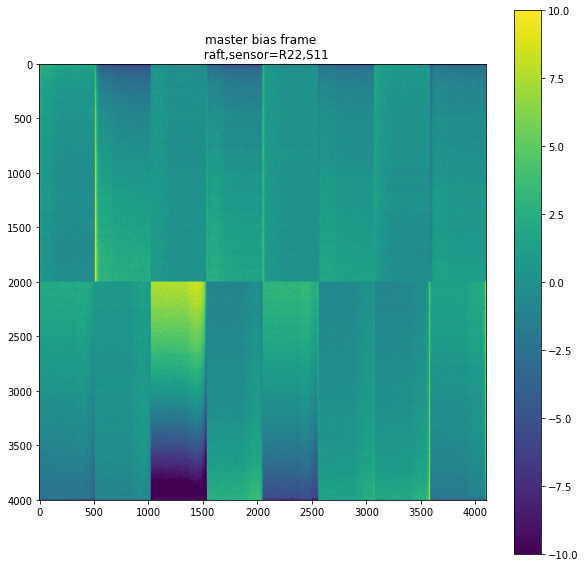

In [7]:
from astropy.io import fits
import matplotlib.pyplot as plt
import glob

biasname=glob.glob(RERUN_DIR + "/bias/*/*.fits")[0]
print(biasname)
bias=fits.getdata(biasname)

plt.figure(figsize=(10,10))
plt.imshow(bias,vmin=-10,vmax=10)
plt.colorbar()
plt.title('master bias frame \n  raft,sensor='+RAFT+','+DETECTOR_NAME)

## Ingest the master bias frame

You can now populate the repository with our first new data, the master bias frame we made. The Pipelines’ ingestImages.py command (called a command-line task) links raw images into a Butler repository, allowing the mapper to organize the data. ingestCalibs.py adds these as files specifically as calibration images for other data from that sensor and time (validity range)

Notice that the first argument to most command-line tasks is the Butler repository. In this case it’s the `DATA` directory.

You can learn about the arguments for command-line tasks with the `-h` flag. For example:
```
ingestImages.py -h
```

In [8]:
# Now ingest the master bias image
args = REPO_DIR + " " + RERUN_DIR + "/bias/*/*.fits" + " --validity 9999" + " --calib " + CALIB_DIR + " --mode=link"
! ingestCalibs.py {args}

root INFO: Loading config overrride file '/opt/lsst/software/stack/stack/miniconda3-4.7.12-448abc6/Linux64/obs_lsst/19.0.0-61-g45cb884/config/ingestCalibs.py'
CameraMapper INFO: Loading Posix exposure registry from /home/quasarpanda/DATA/STACK_CLUB_BOT_TEST
CameraMapper INFO: Loading calib registry from /home/quasarpanda/DATA/STACK_CLUB_BOT_TEST/CALIB/calibRegistry.sqlite3
ingestCalibs.register INFO: Table "bias" exists.  Skipping creation
ingestCalibs.register INFO: Table "dark" exists.  Skipping creation
ingestCalibs.register INFO: Table "flat" exists.  Skipping creation
ingestCalibs.register INFO: Table "fringe" exists.  Skipping creation
ingestCalibs.register INFO: Table "sky" exists.  Skipping creation
ingestCalibs.register INFO: Table "defects" exists.  Skipping creation
ingestCalibs.register INFO: Table "qe_curve" exists.  Skipping creation
ingestCalibs.register INFO: Table "linearizer" exists.  Skipping creation
ingestCalibs WARN: Failed to link /home/quasarpanda/DATA/STACK_CLU

## Now make a master dark

In [12]:
# Now create a master dark
# first make a list of visits
# Five 30 second darks
visits = []
starting_visit = 3019103101871
ending_visit   = 3019103101875
visit = starting_visit
while visit < ending_visit + 1:
    visits.append(visit)
    visit += 1
print(len(visits))

5


In [13]:
# create constructDark args string

args = DATA_DIR + " --calib " + CALIB_DIR + " --rerun " + RERUN_DIR + " --id visit="
for visit in visits:
    if visit != starting_visit:
        args += "^"
    args += str(visit)
args += " detector=%d"%DETECTOR
args += " --batch-type=None" + " -c isr.doCrosstalk=False " +  "--clobber-config"
print(args)
! constructDark.py {args}

/project/shared/BOT/ --calib /home/quasarpanda/DATA/STACK_CLUB_BOT_TEST/CALIB --rerun /home/quasarpanda/DATA/STACK_CLUB_BOT_TEST/calib_construction --id visit=3019103101871^3019103101872^3019103101873^3019103101874^3019103101875 detector=94 --batch-type=None -c isr.doCrosstalk=False --clobber-config
root INFO: Loading config overrride file '/opt/lsst/software/stack/stack/miniconda3-4.7.12-448abc6/Linux64/obs_lsst/19.0.0-61-g45cb884/config/dark.py'
LsstCamMapper WARN: Unable to find valid calib root directory
CameraMapper INFO: Loading exposure registry from /lsstdata/offline/teststand/BOT/gen2repo/registry.sqlite3
CameraMapper INFO: Loading calib registry from /home/quasarpanda/DATA/STACK_CLUB_BOT_TEST/CALIB/calibRegistry.sqlite3
CameraMapper INFO: Loading calib registry from /home/quasarpanda/DATA/STACK_CLUB_BOT_TEST/CALIB/calibRegistry.sqlite3
root WARN: Unexpected ID visit; guessing type is "str"
dark FATAL: Failed in task initialization: Version mismatch (coadd_utils: 19.0.0-2-g15a

## Look at the new master dark

/home/quasarpanda/DATA/STACK_CLUB_BOT_TEST/calib_construction/dark/2019-11-01/dark-R22-S11-det094_2019-11-01.fits


Text(0.5, 1.0, 'master dark frame \n  raft,sensor=R22,S11')

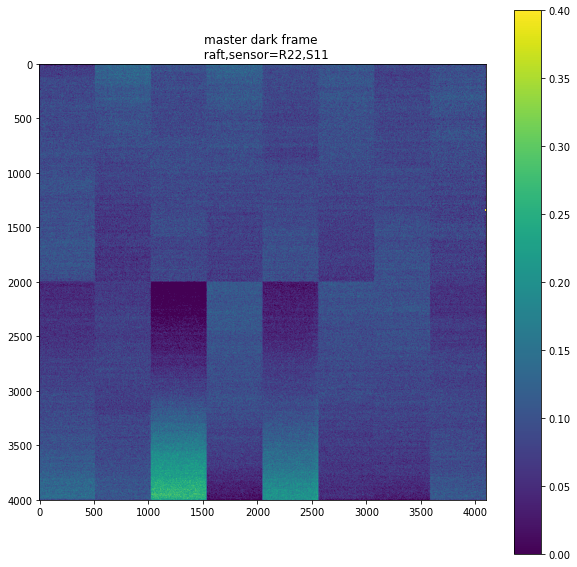

In [15]:
darkname=glob.glob(RERUN_DIR + "/dark/*/*.fits")[0]
print(darkname)
dark=fits.getdata(darkname)

plt.figure(figsize=(10,10))
plt.imshow(dark,vmin=0,vmax=0.4)
plt.colorbar()
plt.title('master dark frame \n  raft,sensor='+RAFT+','+DETECTOR_NAME)

## Ingest the master dark frame

In [14]:
# Now ingest the master dark image
args = REPO_DIR + " " + \
       RERUN_DIR + "/dark/*/*.fits" + \
       " --validity 9999" + \
       " --calib " + CALIB_DIR + \
       " --mode=link"

! ingestCalibs.py {args}

root INFO: Loading config overrride file '/opt/lsst/software/stack/stack/miniconda3-4.7.12-448abc6/Linux64/obs_lsst/19.0.0-61-g45cb884/config/ingestCalibs.py'
CameraMapper INFO: Loading Posix exposure registry from /home/quasarpanda/DATA/STACK_CLUB_BOT_TEST
CameraMapper INFO: Loading calib registry from /home/quasarpanda/DATA/STACK_CLUB_BOT_TEST/CALIB/calibRegistry.sqlite3
ingestCalibs.register INFO: Table "bias" exists.  Skipping creation
ingestCalibs.register INFO: Table "dark" exists.  Skipping creation
ingestCalibs.register INFO: Table "flat" exists.  Skipping creation
ingestCalibs.register INFO: Table "fringe" exists.  Skipping creation
ingestCalibs.register INFO: Table "sky" exists.  Skipping creation
ingestCalibs.register INFO: Table "defects" exists.  Skipping creation
ingestCalibs.register INFO: Table "qe_curve" exists.  Skipping creation
ingestCalibs.register INFO: Table "linearizer" exists.  Skipping creation
ingestCalibs WARN: Failed to link /home/quasarpanda/DATA/STACK_CLU

## Similarly, make a master flat

In [16]:
# Now create a master flat
visits = []
starting_visit = 3019110200307
ending_visit = 3019110200308

visit = starting_visit
while visit < ending_visit + 1:
    visits.append(visit)
    visit += 1
print(len(visits))

2


In [17]:
args = DATA_DIR + " --calib " + CALIB_DIR + " --rerun " + RERUN_DIR + " --id visit="
for visit in visits:
    if visit != starting_visit:
        args += "^"
    args += str(visit)

args += " detector=%d"%DETECTOR
args += " --batch-type=None" + " -c isr.doCrosstalk=False" + " --clobber-config"

print(args)

! constructFlat.py {args}

/project/shared/BOT/ --calib /home/quasarpanda/DATA/STACK_CLUB_BOT_TEST/CALIB --rerun /home/quasarpanda/DATA/STACK_CLUB_BOT_TEST/calib_construction --id visit=3019110200307^3019110200308 detector=94 --batch-type=None -c isr.doCrosstalk=False --clobber-config
root INFO: Loading config overrride file '/opt/lsst/software/stack/stack/miniconda3-4.7.12-448abc6/Linux64/obs_lsst/19.0.0-61-g45cb884/config/flat.py'
LsstCamMapper WARN: Unable to find valid calib root directory
CameraMapper INFO: Loading exposure registry from /lsstdata/offline/teststand/BOT/gen2repo/registry.sqlite3
CameraMapper INFO: Loading calib registry from /home/quasarpanda/DATA/STACK_CLUB_BOT_TEST/CALIB/calibRegistry.sqlite3
CameraMapper INFO: Loading calib registry from /home/quasarpanda/DATA/STACK_CLUB_BOT_TEST/CALIB/calibRegistry.sqlite3
root WARN: Unexpected ID visit; guessing type is "str"
flat FATAL: Failed in task initialization: Version mismatch (botocore.session: 1.16.4 vs 1.16.11; pex_exceptions: 19.0.0-3-ga84a0

## Look at the new master flat

Notice the spots (these are also known as _dust moats_)

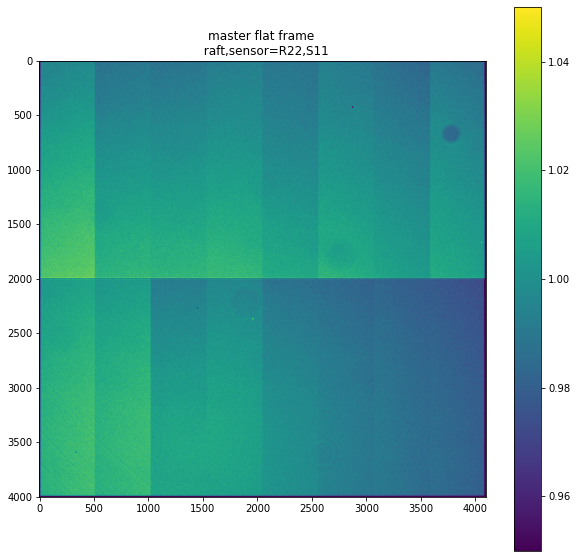

In [18]:
flatname=glob.glob(RERUN_DIR + "/flat/*/*/*.fits")[0]
#print(flatname)
flat=fits.getdata(flatname)

plt.figure(figsize=(10,10))
plt.imshow(flat,vmin=0.95,vmax=1.05)
plt.colorbar()
plt.title('master flat frame \n  raft,sensor='+RAFT+','+DETECTOR_NAME)
plt.savefig('/home/quasarpanda/master_flat.png',dpi=300)

## Ingest the master flat frame

In [19]:
# Now ingest the master flat images
args = REPO_DIR + " " + RERUN_DIR + \
       "/flat/*/*/*.fits" + \
       " --validity 9999" + \
       " --calib " + CALIB_DIR + \
       " --mode=link"

! ingestCalibs.py {args}

root INFO: Loading config overrride file '/opt/lsst/software/stack/stack/miniconda3-4.7.12-448abc6/Linux64/obs_lsst/19.0.0-61-g45cb884/config/ingestCalibs.py'
CameraMapper INFO: Loading Posix exposure registry from /home/quasarpanda/DATA/STACK_CLUB_BOT_TEST
CameraMapper INFO: Loading calib registry from /home/quasarpanda/DATA/STACK_CLUB_BOT_TEST/CALIB/calibRegistry.sqlite3
ingestCalibs.register INFO: Table "bias" exists.  Skipping creation
ingestCalibs.register INFO: Table "dark" exists.  Skipping creation
ingestCalibs.register INFO: Table "flat" exists.  Skipping creation
ingestCalibs.register INFO: Table "fringe" exists.  Skipping creation
ingestCalibs.register INFO: Table "sky" exists.  Skipping creation
ingestCalibs.register INFO: Table "defects" exists.  Skipping creation
ingestCalibs.register INFO: Table "qe_curve" exists.  Skipping creation
ingestCalibs.register INFO: Table "linearizer" exists.  Skipping creation
ingestCalibs WARN: Failed to link /home/quasarpanda/DATA/STACK_CLU

## Now get a spot image to run ISR (Instrument Signature Removal) on

In [21]:
from lsst.daf.persistence import Butler

spot_visit = 3019103101985  
#This is a medium exposure
butler = Butler(DATA_DIR, calibRoot=CALIB_DIR)
spotDataRef = butler.dataRef('raw', raftName=RAFT,
                         	detectorName=DETECTOR_NAME,
                         	visit=spot_visit)

## Configure an IsrTask and run it inside of python

In [22]:
# configure an IsrTask
from lsst.ip.isr.isrTask import IsrTask
isrConfig = IsrTask.ConfigClass()
isrConfig.doLinearize = False
isrConfig.doBias = True     # use the calibs we made!
isrConfig.doFlat = True
isrConfig.doDark = True
isrConfig.doFringe = False   # we did not do these, skip
isrConfig.doDefect = False
isrConfig.doWrite = False
isrConfig.fallbackFilterName = 'SDSSi~empty'  #  Both of these are needed
isrConfig.useFallbackDate = True          	#  Both of these are needed
isrTask = IsrTask(config=isrConfig)
# run the task and take the exposure
postIsrSpot = isrTask.run(spotDataRef).exposure

## View the spot images after ISR

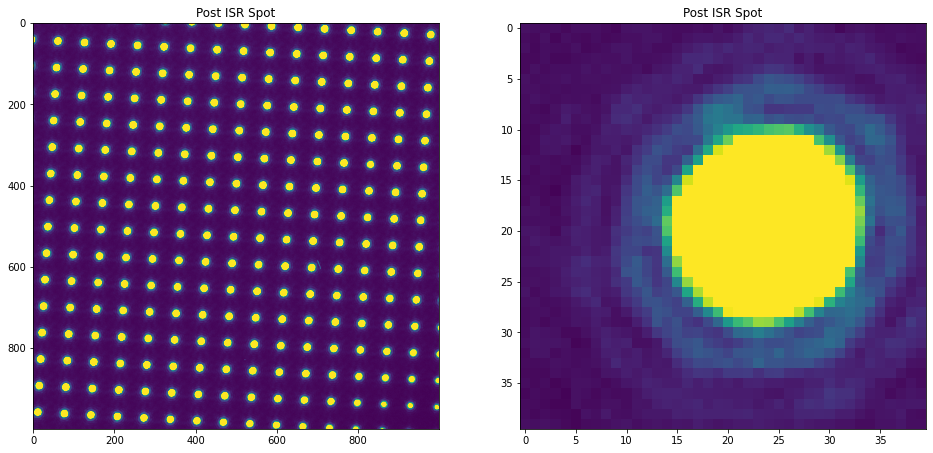

In [23]:
# Now just look at a portion of the images
plt.figure(figsize=(16,16))    
plt.subplot(1,2,1)
plt.title("Post ISR Spot")
plt.imshow(postIsrSpot.image.array[2000:3000,2000:3000],vmin=0,vmax=1000)
plt.subplot(1,2,2)
plt.title("Post ISR Spot")
plt.imshow(postIsrSpot.image.array[2510:2550,2535:2575],vmin=0,vmax=1000)

## Find the spots in the corrected image

In [24]:
# Now let's try finding the spots
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask, CharacterizeImageConfig
charConfig = CharacterizeImageConfig()

charConfig.installSimplePsf.fwhm = 1.0   # save a step, start with a guess
charConfig.doMeasurePsf = False          # but you could measure it
charConfig.doApCorr = False              # a lot of nice steps we can skip
charConfig.doDeblend = False
charConfig.repair.doCosmicRay = True
charConfig.repair.doInterpolate = False   
charConfig.detection.background.binSize = 32    # what scale to est. bg
charConfig.detection.minPixels = 20             # min number of pixels
charTask = CharacterizeImageTask(config=charConfig)
charResult = charTask.run(postIsrSpot)

print("Detected ",len(charResult.sourceCat)," objects ")

Detected  2264  objects 


## Display the spots found, using their centroid

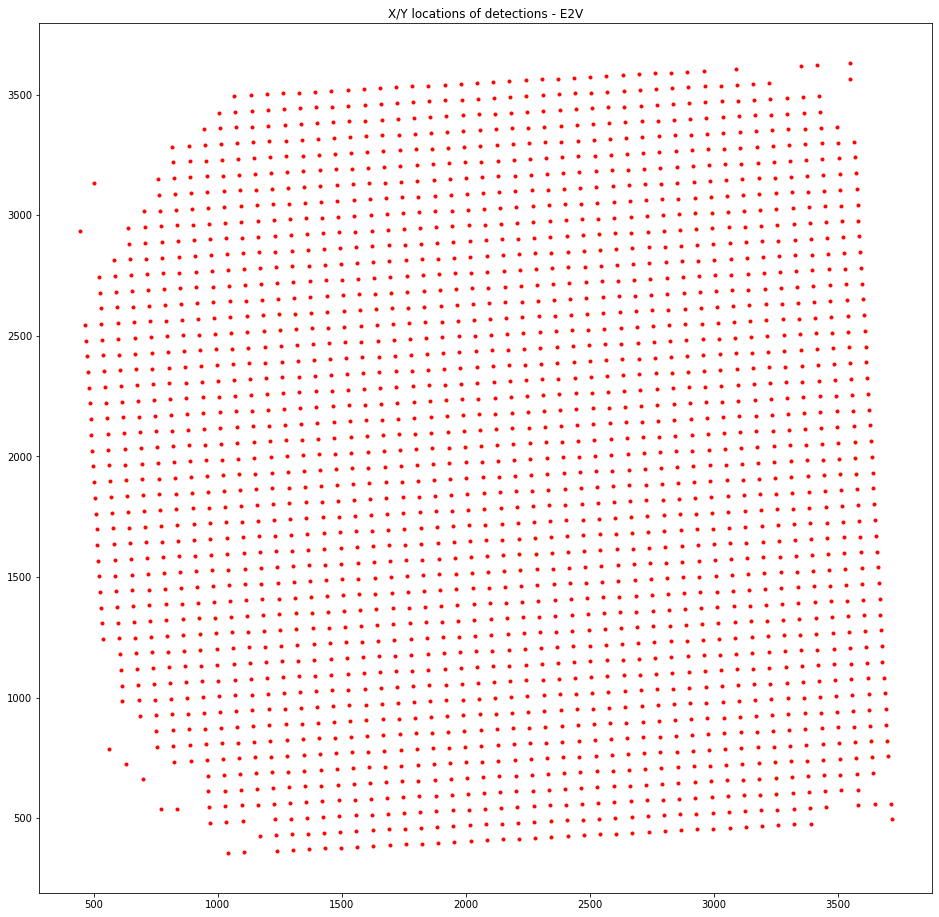

In [25]:
plt.figure(figsize=(16,16))
plt.title('X/Y locations of detections - E2V')
plt.plot(charResult.sourceCat['base_SdssCentroid_x'],
         charResult.sourceCat['base_SdssCentroid_y'],'r.')

## Playground...

Below is a place to play around with your spot image and catalog. For example, 

* Explore the catalog produced by the single fits image using data visualization tools
* Turn off bias and dark correction, or cosmic ray interpolation and re-do detection
* Try lowering the number of pixels for detection
* Look at the regions around cosmic rays.
* ...!

Add your own playground example...

## Playground: Investigating Cosmic Rays

{'BAD': 0, 'CR': 3, 'DETECTED': 5, 'DETECTED_NEGATIVE': 6, 'EDGE': 4, 'INTRP': 2, 'NO_DATA': 8, 'SAT': 1, 'SUSPECT': 7, 'UNMASKEDNAN': 9}
[1043 1043 1043 1043 1188 1189 1189 1190 1191 1711 1712 1713 1713 1714
 1714 1714 1714 1714 1714 1715 1715 1715 1715 1715 1716 1716 1716 1716
 1717 1717 2601 2602 2603 2603]
[3747 3748 3749 3750 2775 2774 2775 2775 2774  656  656  656  657  655
  656  657  658  659  660  655  657  658  659  660  656  657  658  659
  657  659 2707 2707 2707 2708]
[12 12 12 12 44 44 44 44 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 44 44 44 44]


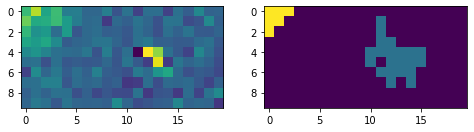

In [26]:
import numpy as np

# Figure out which pixels are identified as cosmic rays
print(postIsrSpot.mask.getMaskPlaneDict())
bit = 2**postIsrSpot.mask.getMaskPlaneDict()['CR']
# Or even better
bit = postIsrSpot.getMask().getPlaneBitMask('CR')

# Select interpolated pixels
sel = (postIsrSpot.mask.array & bit) > 0
sel.sum()

# Find a region to make cutouts around
idx,idy = np.where(sel)
print(idx)
print(idy)
print(postIsrSpot.mask.array[idx,idy])

# Make a cutout
fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].imshow(postIsrSpot.image.array[1710:1720,645:665])
ax[1].imshow(postIsrSpot.mask.array[1710:1720,645:665])


- Looking at regions around a cosmic ray

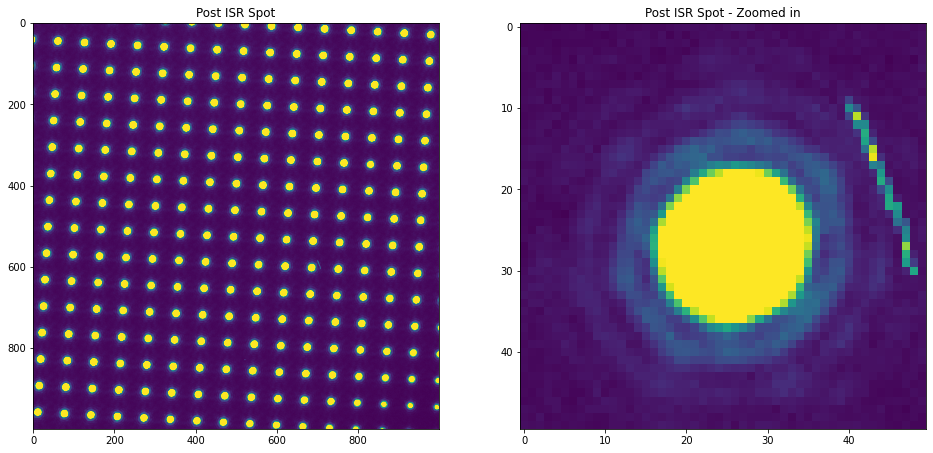

In [39]:
# configure an IsrTask
from lsst.ip.isr.isrTask import IsrTask
isrConfig = IsrTask.ConfigClass()
isrConfig.doLinearize = False
isrConfig.doBias = True     # use the calibs we made!
isrConfig.doFlat = True
isrConfig.doDark = True
isrConfig.doFringe = False   # we did not do these, skip
isrConfig.doDefect = False
isrConfig.doWrite = False
isrConfig.fallbackFilterName = 'SDSSi~empty'  #  Both of these are needed
isrConfig.useFallbackDate = True              #  Both of these are needed
isrTask = IsrTask(config=isrConfig)
# run the task and take the exposure
postIsrSpot = isrTask.run(spotDataRef).exposure
# Now just look at a portion of the images
plt.figure(figsize=(16,16))    
plt.subplot(1,2,1)
plt.title("Post ISR Spot")
plt.imshow(postIsrSpot.image.array[2000:3000,2000:3000],vmin=0,vmax=1000)
plt.subplot(1,2,2)
plt.title("Post ISR Spot - Zoomed in")
plt.imshow(postIsrSpot.image.array[2575:2625,2660:2710],vmin=0,vmax=1000)
#plt.imshow(postIsrSpot.mask.array[2575:2625,2660:2710])
#plt.savefig('/home/quasarpanda/post_isr_spot_CR.png', dpi=300)

## Other useful commands

Thanks to Chris Waters, Melissa Graham

1. Getting meta-data (here for the ISR Spot) wrapped in a dictionary

In [29]:
postIsrSpot.getMetadata().toDict()

{'SIMPLE': True,
 'BITPIX': 8,
 'NAXIS': 0,
 'EXTEND': True,
 'DATE': '2019-11-01T02:50:08.837',
 'DATE-OBS': '2019-11-01T02:50:06.589',
 'MJD': 58788.11815783568,
 'MJD-OBS': 58788.11813181732,
 'RUNNUM': '6868D',
 'IMAGETAG': 'aa7f8011f78111c9',
 'TSTAND': 'BOT',
 'INSTRUME': 'lsstCam',
 'CONTNUM': '18ee3eaa',
 'SEQFILE': 'FP_E2V_2s_ir2_v3.seq',
 'CCDSLOT': 'S11',
 'RAFTBAY': 'R22',
 'LSST_NUM': 'E2V-CCD250-382',
 'RAFTNAME': 'LCA-11021_RTM-024',
 'TESTTYPE': 'SPOT_FLAT',
 'IMGTYPE': 'SPOT',
 'SEQNUM': 1985,
 'DETSIZE': '[1:4096,1:4004]',
 'CCDTEMP': -99.20064505044516,
 'EXPTIME': 16.0,
 'BINX': 1,
 'BINY': 1,
 'HEADVER': 2,
 'CCDGAIN': 1.0,
 'CCDNOISE': 10.0,
 'DATE-TRG': '2019-11-01T02:50:06.589',
 'MJD-TRG': 58788.11813181732,
 'FIRMWARE': '31385004',
 'PLATFORM': 'ir2-camera',
 'DAQVERS': 'R4-V2.7 2019-10-25T19:27:48Z (52b5939b)',
 'DAQPART': 'camera',
 'DAQFOLD': 'raw',
 'DAQANNOT': '',
 'OBSID': 'MC_C_20191031_001985',
 'TELCODE': 'MC',
 'CONTRLLR': 'C',
 'DAYOBS': '20191031',

to get Mask 

In [30]:
postIsrSpot.getMask().getPlaneBitMask(['CR', 'INTRP'])

12

Detected  1953  objects 


Text(0.5, 1.0, 'PSF YY vs. Y COORD')

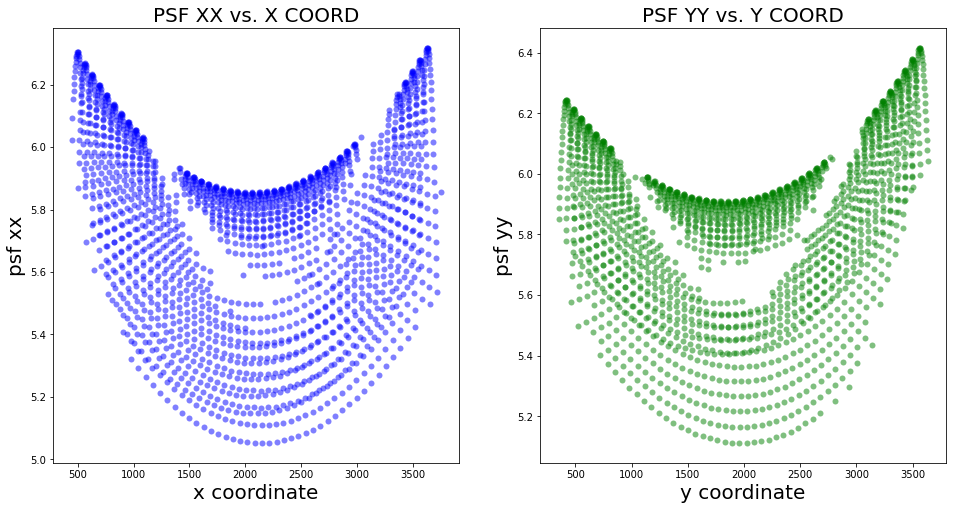

In [40]:
# Now let's try finding the spots
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask, CharacterizeImageConfig
charConfig = CharacterizeImageConfig()

charConfig.installSimplePsf.fwhm = 1.0   # save a step, start with a guess
charConfig.doMeasurePsf = True          # measuring it
charConfig.doApCorr = False              # a lot of nice steps we can skip
charConfig.doDeblend = False
charConfig.repair.doCosmicRay = True
charConfig.repair.doInterpolate = True   
charConfig.detection.background.binSize = 32    # what scale to est. bg
charConfig.detection.minPixels = 20             # min number of pixels
charTask = CharacterizeImageTask(config=charConfig)
charResult = charTask.run(postIsrSpot)

print("Detected ",len(charResult.sourceCat)," objects ")

#######################

plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.plot(charResult.sourceCat['base_SdssCentroid_x'],
         charResult.sourceCat['base_SdssShape_psf_xx'],
         'o',alpha=0.5, mew=0, color='blue')
plt.xlabel('x coordinate', fontsize=20)
plt.ylabel('psf xx', fontsize=20)
plt.title('PSF XX vs. X COORD', fontsize=20)

plt.subplot(1,2,2)
plt.plot(charResult.sourceCat['base_SdssCentroid_y'],
         charResult.sourceCat['base_SdssShape_psf_yy'],
         'o',alpha=0.5, mew=0, color='green')
plt.xlabel('y coordinate', fontsize=20)
plt.ylabel('psf yy', fontsize=20)
plt.title('PSF YY vs. Y COORD', fontsize=20)

The following are some basic plots. Inspecting the parameters from the _Source Catalog_ (as above)

Text(0, 0.5, 'base_SdssCentroid_y')

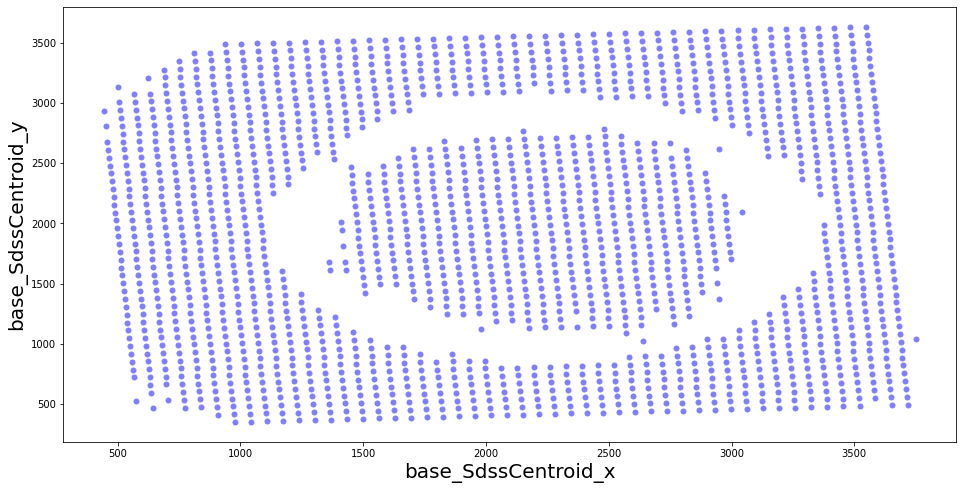

In [42]:
plt.figure(figsize=(16,8))
plt.plot(charResult.sourceCat['base_SdssCentroid_x'],
         charResult.sourceCat['base_SdssCentroid_y'],
         'o',alpha=0.5, mew=0, color='blue')

plt.xlabel('base_SdssCentroid_x', fontsize=20)
plt.ylabel('base_SdssCentroid_y', fontsize=20)
#plt.title('PSF YY vs. Y COORD', fontsize=20)

Querying the header column names

In [43]:
charResult.sourceCat[0]

<class 'lsst.afw.table.SourceRecord'>
id: 1
coord_ra: nan rad
coord_dec: nan rad
parent: 0
calib_psf_candidate: 0
calib_psf_used: 0
calib_psf_reserved: 0
base_SdssCentroid_x: 976.908
base_SdssCentroid_y: 351.662
base_SdssCentroid_xErr: 0.0413651
base_SdssCentroid_yErr: 0.0437786
base_SdssCentroid_flag: 0
base_SdssCentroid_flag_edge: 0
base_SdssCentroid_flag_noSecondDerivative: 0
base_SdssCentroid_flag_almostNoSecondDerivative: 0
base_SdssCentroid_flag_notAtMaximum: 0
base_SdssCentroid_flag_resetToPeak: 0
base_SdssCentroid_flag_badError: 0
base_SdssShape_xx: 5.37249
base_SdssShape_yy: 5.57343
base_SdssShape_xy: 0.316633
base_SdssShape_xxErr: 0.199516
base_SdssShape_yyErr: 0.143933
base_SdssShape_xyErr: 0.206978
base_SdssShape_x: 976.908
base_SdssShape_y: 351.661
base_SdssShape_instFlux: 12461.6
base_SdssShape_instFluxErr: 231.391
base_SdssShape_psf_xx: 5.32209
base_SdssShape_psf_yy: 5.85105
base_SdssShape_psf_xy: 0.592572
base_SdssShape_instFlux_xx_Cov: -23.083
base_SdssShape_instFlux_y

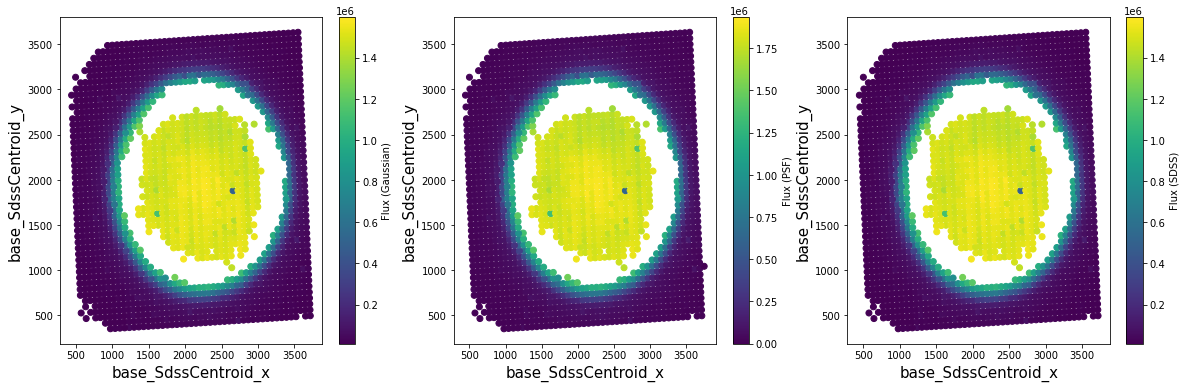

In [49]:
#plt.figure(figsize=(16,8))
plt.figure(figsize=(20,6))

plt.subplot(131)
plt.scatter(charResult.sourceCat['base_SdssCentroid_x'], 
            charResult.sourceCat['base_SdssCentroid_y'], 
            c=charResult.sourceCat['base_GaussianFlux_instFlux'])
plt.xlabel('base_SdssCentroid_x', fontsize=15)
plt.ylabel('base_SdssCentroid_y', fontsize=15)
plt.colorbar(label='Flux (Gaussian)')


plt.subplot(132)
plt.scatter(charResult.sourceCat['base_SdssCentroid_x'], 
            charResult.sourceCat['base_SdssCentroid_y'], 
            c=charResult.sourceCat['base_PsfFlux_instFlux'])
plt.xlabel('base_SdssCentroid_x', fontsize=15)
plt.ylabel('base_SdssCentroid_y', fontsize=15)
plt.colorbar(label='Flux (PSF)')


plt.subplot(133)
plt.scatter(charResult.sourceCat['base_SdssCentroid_x'], 
            charResult.sourceCat['base_SdssCentroid_y'], 
            c=charResult.sourceCat['base_SdssShape_instFlux'])
plt.xlabel('base_SdssCentroid_x', fontsize=15)
plt.ylabel('base_SdssCentroid_y', fontsize=15)
plt.colorbar(label='Flux (SDSS)')


#base_GaussianFlux_instFluxErr

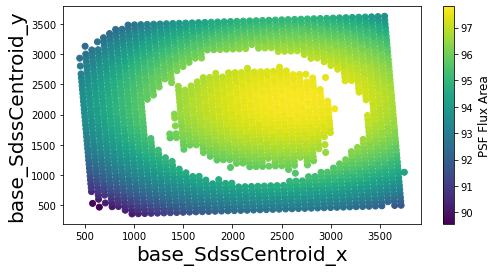

In [52]:
plt.figure(figsize=(8,4))

#plt.subplot(131)
plt.scatter(charResult.sourceCat['base_SdssCentroid_x'], 
            charResult.sourceCat['base_SdssCentroid_y'], 
            c=charResult.sourceCat['base_PsfFlux_area'])
plt.xlabel('base_SdssCentroid_x', fontsize=20)
plt.ylabel('base_SdssCentroid_y', fontsize=20)

cb = plt.colorbar()
cb.set_label(label='PSF Flux Area',fontsize=12)


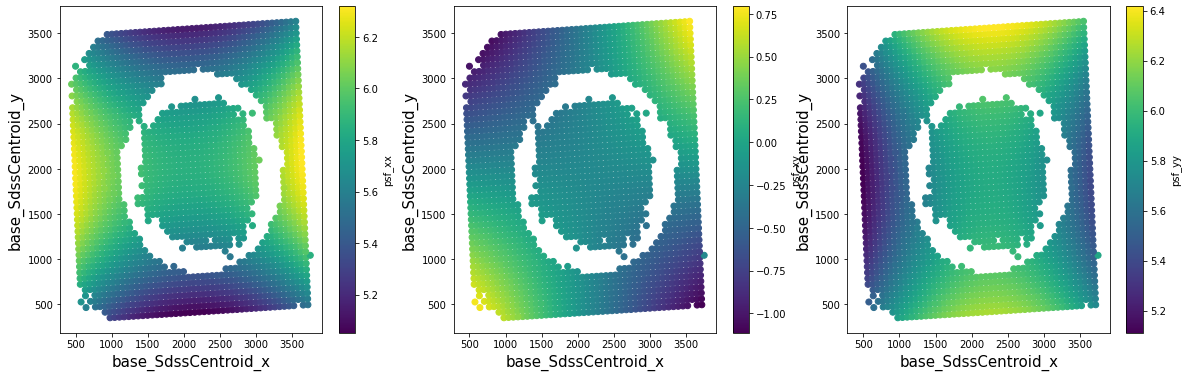

In [53]:
#plt.figure(figsize=(16,8))
plt.figure(figsize=(20,6))

plt.subplot(131)
plt.scatter(charResult.sourceCat['base_SdssCentroid_x'], 
            charResult.sourceCat['base_SdssCentroid_y'], 
            c=charResult.sourceCat['base_SdssShape_psf_xx'])
plt.xlabel('base_SdssCentroid_x', fontsize=15)
plt.ylabel('base_SdssCentroid_y', fontsize=15)
plt.colorbar(label='psf_xx')

plt.subplot(132)
plt.scatter(charResult.sourceCat['base_SdssCentroid_x'], 
            charResult.sourceCat['base_SdssCentroid_y'], 
            c=charResult.sourceCat['base_SdssShape_psf_xy'])
plt.xlabel('base_SdssCentroid_x', fontsize=15)
plt.ylabel('base_SdssCentroid_y', fontsize=15)
plt.colorbar(label='psf_xy')

plt.subplot(133)
plt.scatter(charResult.sourceCat['base_SdssCentroid_x'], 
            charResult.sourceCat['base_SdssCentroid_y'], 
            c=charResult.sourceCat['base_SdssShape_psf_yy'])
plt.xlabel('base_SdssCentroid_x', fontsize=15)
plt.ylabel('base_SdssCentroid_y', fontsize=15)
plt.colorbar(label='psf_yy')


#base_GaussianFlux_instFluxErr

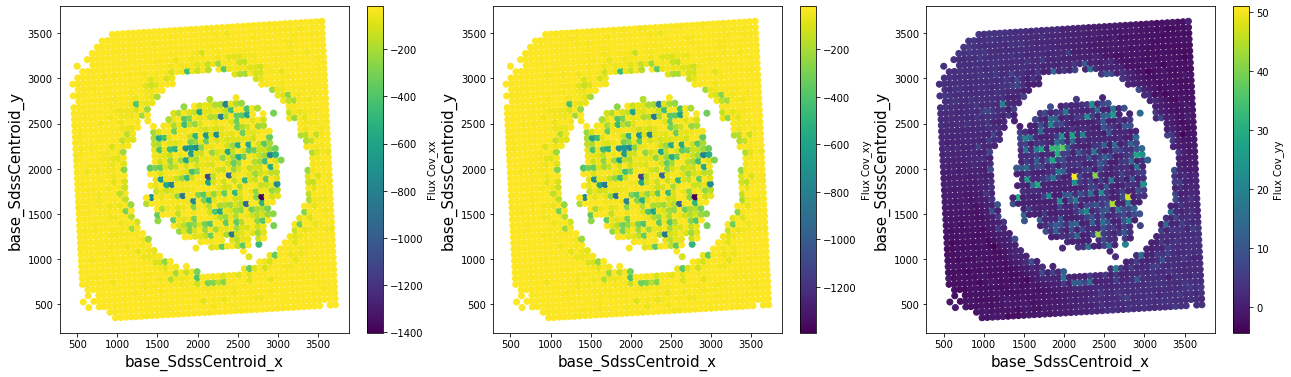

In [55]:
#plt.figure(figsize=(16,8))
plt.figure(figsize=(22,6))

plt.subplot(131)
plt.scatter(charResult.sourceCat['base_SdssCentroid_x'], 
            charResult.sourceCat['base_SdssCentroid_y'], 
            c=charResult.sourceCat['base_SdssShape_instFlux_xx_Cov'])
plt.xlabel('base_SdssCentroid_x', fontsize=15)
plt.ylabel('base_SdssCentroid_y', fontsize=15)
plt.colorbar(label='Flux Cov_xx')

plt.subplot(132)
plt.scatter(charResult.sourceCat['base_SdssCentroid_x'], 
            charResult.sourceCat['base_SdssCentroid_y'], 
            c=charResult.sourceCat['base_SdssShape_instFlux_xy_Cov'])
plt.xlabel('base_SdssCentroid_x', fontsize=15)
plt.ylabel('base_SdssCentroid_y', fontsize=15)
plt.colorbar(label='Flux Cov_xy')

plt.subplot(133)
plt.scatter(charResult.sourceCat['base_SdssCentroid_x'], 
            charResult.sourceCat['base_SdssCentroid_y'], 
            c=charResult.sourceCat['base_SdssShape_instFlux_yy_Cov'])
plt.xlabel('base_SdssCentroid_x', fontsize=15)
plt.ylabel('base_SdssCentroid_y', fontsize=15)
plt.colorbar(label='Flux Cov_yy')


#base_GaussianFlux_instFluxErr